In [32]:
import os
import pickle
import numpy as np
import random
from scipy.ndimage import uniform_filter1d, gaussian_filter1d
from tslearn.utils import to_time_series_dataset
from tslearn.neighbors import KNeighborsTimeSeriesClassifier, \
    KNeighborsTimeSeries
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

In [91]:
training_directory = '/home/tyler/Documents/Matt3r/imu-classification/DATA/standardized/stage5_standartized/train'
validation_directory = '/home/tyler/Documents/Matt3r/imu-classification/DATA/standardized/stage5_standartized/val'

TRAIN_SAMPLES_PER_CLASS = 100
VAL_SAMPLES_PER_CLASS = 100
NUM_CLUSTERS = [4,2,1,1,1,2]

def shuffle_data_set(X, Y=None, size=None):
    indices = list(range(len(X)))
    random.shuffle(indices)
    shuffled_X = [X[i] for i in indices][:size]
    if Y is not None:
        shuffled_Y = [Y[i] for i in indices][:size]
        return shuffled_X, shuffled_Y
    else: return shuffled_X

def compute_clusters(X, num_clusters):
    km = TimeSeriesKMeans(num_clusters, metric="softdtw")
    km.fit(X)
    return km.cluster_centers_

# collect data for either training or validation
def get_data(folder_path, n_samples, n_clusters=None, train=False):
    num_classes = 0
    X = []
    Y = []
    labels = []
    for id, folder in enumerate(os.listdir(folder_path)):
        if id in [0,1,2,3,4,5]:
            labels.append(folder)
            folder_list = []
            for file_name in os.listdir(os.path.join(folder_path, folder)):
                if file_name.endswith(".npy"):
                    file_path = os.path.join(folder_path, folder, file_name)
                    data = np.load(file_path, allow_pickle=True)
                    folder_list.append(data[:,:].T)
            if train:
                train_set = to_time_series_dataset(shuffle_data_set(folder_list, size=n_samples))
                clusters = compute_clusters(train_set, n_clusters[id])
                X.append(clusters)
                Y += [id] * n_clusters[id]
            else:
                X += shuffle_data_set(folder_list, size=n_samples)
                Y += [id] * n_samples
        if id >= num_classes:
            num_classes += 1
    if train:
        X_ts = np.concatenate(X, axis=0)
    else:
        X_ts = to_time_series_dataset(X)
    # shuffle the datasets
    # X_shuffled, Y_shuffled = shuffle_data_set(X, Y, n_samples * num_classes)
    X_shuffled, Y_shuffled = X_ts, Y
    return X_shuffled, np.array(Y_shuffled), labels

ts_X_train, ts_Y_train, class_labels = get_data(validation_directory, TRAIN_SAMPLES_PER_CLASS, NUM_CLUSTERS, train=True)
ts_X_val, ts_Y_val, _ = get_data(training_directory, VAL_SAMPLES_PER_CLASS)

0.4216666666666667


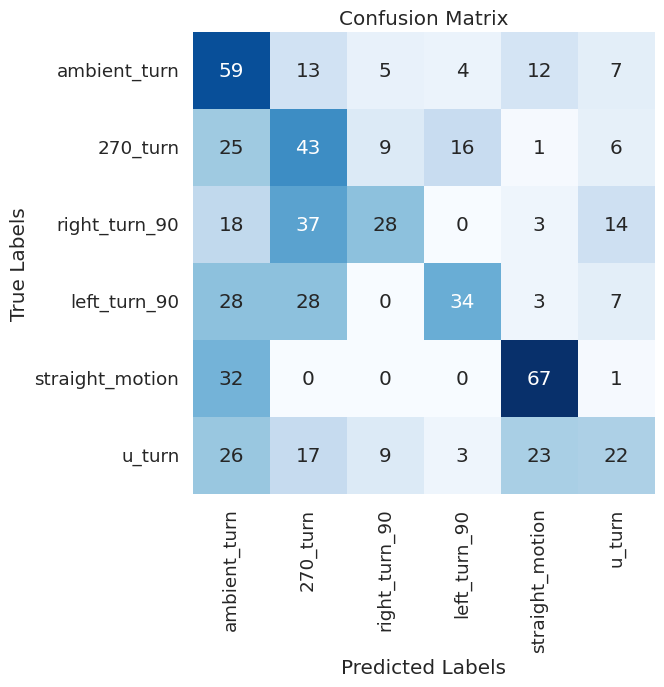

In [116]:
knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")
knn_clf.fit(ts_X_train, ts_Y_train)
predicted_labels = knn_clf.predict(ts_X_val)

# plot the confusion matrix
cm = confusion_matrix(ts_Y_val, predicted_labels)

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

print(accuracy_score(ts_Y_val, predicted_labels))
plot_confusion_matrix(cm, class_labels)

In [70]:
def predict_accuracy(n_clusters, k):
    training_directory = '/home/tyler/Documents/Matt3r/imu-classification/DATA/standardized/stage5_standartized/train'
    validation_directory = '/home/tyler/Documents/Matt3r/imu-classification/DATA/standardized/stage5_standartized/val'
    TRAIN_SAMPLES_PER_CLASS = 100
    VAL_SAMPLES_PER_CLASS = 100

    ts_X_train, ts_Y_train, class_labels = get_data(validation_directory, TRAIN_SAMPLES_PER_CLASS, n_clusters, train=True)
    ts_X_val, ts_Y_val, _ = get_data(training_directory, VAL_SAMPLES_PER_CLASS)

    knn_clf = KNeighborsTimeSeriesClassifier(n_neighbors=k, metric="dtw")
    knn_clf.fit(ts_X_train, ts_Y_train)
    predicted_labels = knn_clf.predict(ts_X_val)

    return n_clusters, k, ts_Y_val, predicted_labels, accuracy_score(ts_Y_val, predicted_labels)

tests = []
clusters_tests = [1,2,3,4,5,6,7,8,9,10,25,50]
k_tests = [1,3,4,5,6,7,8,9,10]
for n in clusters_tests:
    for k in k_tests:
        if k <= n:
            result = predict_accuracy(n, k)
            tests.append(result)
            print(f'n={n}, k={k}, accuracy={result[4]}')

n=1, k=1, accuracy=0.54
n=2, k=1, accuracy=0.5366666666666666
n=3, k=1, accuracy=0.5216666666666666
n=3, k=3, accuracy=0.37166666666666665
n=4, k=1, accuracy=0.5316666666666666
n=4, k=3, accuracy=0.35333333333333333
n=4, k=4, accuracy=0.30833333333333335
n=5, k=1, accuracy=0.45666666666666667
n=5, k=3, accuracy=0.4866666666666667
n=5, k=4, accuracy=0.5133333333333333
n=5, k=5, accuracy=0.43166666666666664
n=6, k=1, accuracy=0.52
n=6, k=3, accuracy=0.40166666666666667
n=6, k=4, accuracy=0.49166666666666664
n=6, k=5, accuracy=0.43833333333333335
n=6, k=6, accuracy=0.455
n=7, k=1, accuracy=0.4816666666666667
n=7, k=3, accuracy=0.4216666666666667
n=7, k=4, accuracy=0.48333333333333334
n=7, k=5, accuracy=0.48
n=7, k=6, accuracy=0.42
n=7, k=7, accuracy=0.495
n=8, k=1, accuracy=0.4766666666666667
n=8, k=3, accuracy=0.4166666666666667
n=8, k=4, accuracy=0.5283333333333333
n=8, k=5, accuracy=0.465
n=8, k=6, accuracy=0.525
n=8, k=7, accuracy=0.47833333333333333
n=8, k=8, accuracy=0.4766666666666

# Testing UMAP

In [3]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [4]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [5]:
penguins = pd.read_csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins.csv")
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [6]:
penguins = penguins.dropna()
penguins.species.value_counts()

species
Adelie       146
Gentoo       119
Chinstrap     68
Name: count, dtype: int64

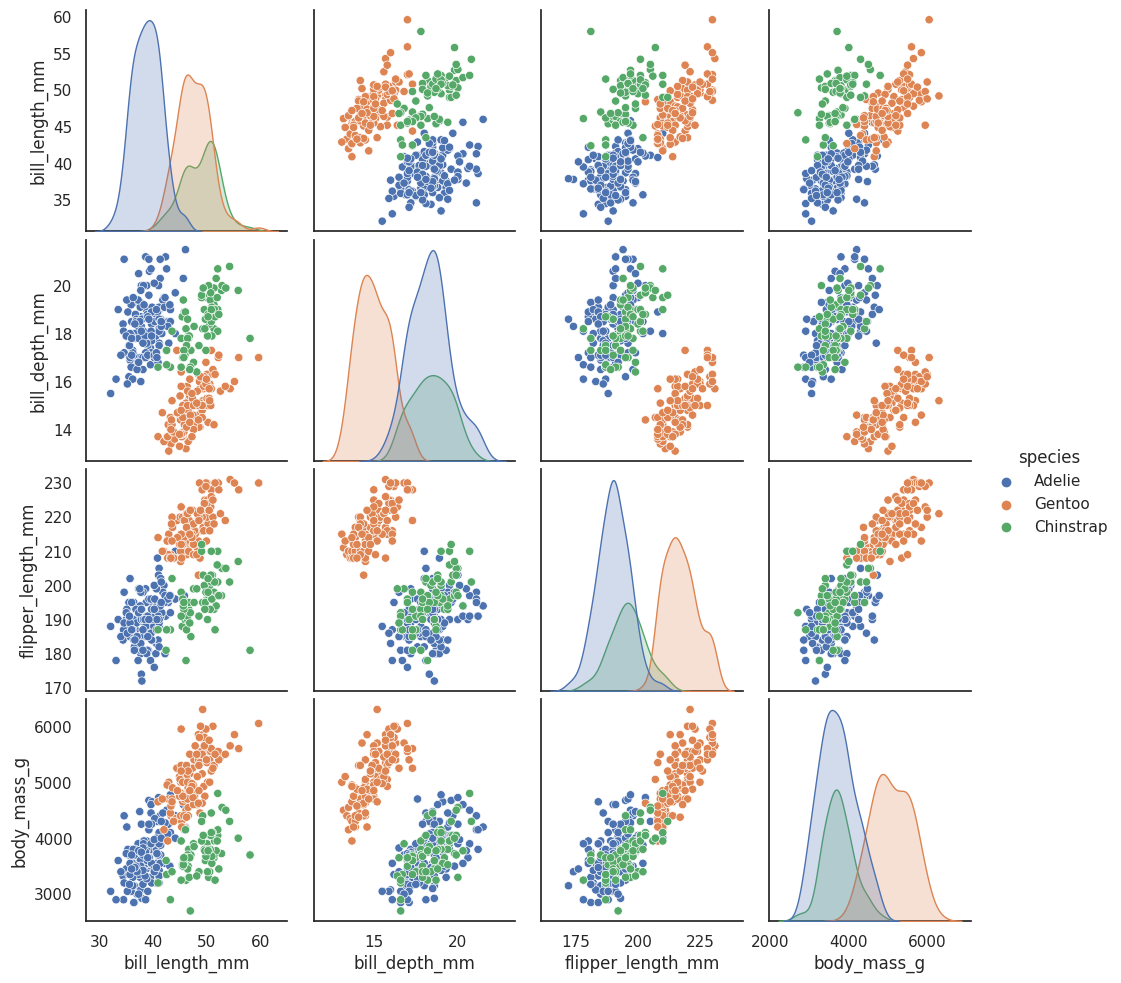

In [7]:
sns.pairplot(penguins.drop("year", axis=1), hue='species');

In [1]:
import umap

/home/tyler/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/tyler/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/tyler/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The '

In [2]:
reducer = umap.UMAP()

In [8]:
penguin_data = penguins[
    [
        "bill_length_mm",
        "bill_depth_mm",
        "flipper_length_mm",
        "body_mass_g",
    ]
].values
scaled_penguin_data = StandardScaler().fit_transform(penguin_data)

In [9]:
embedding = reducer.fit_transform(scaled_penguin_data)
embedding.shape

(333, 2)

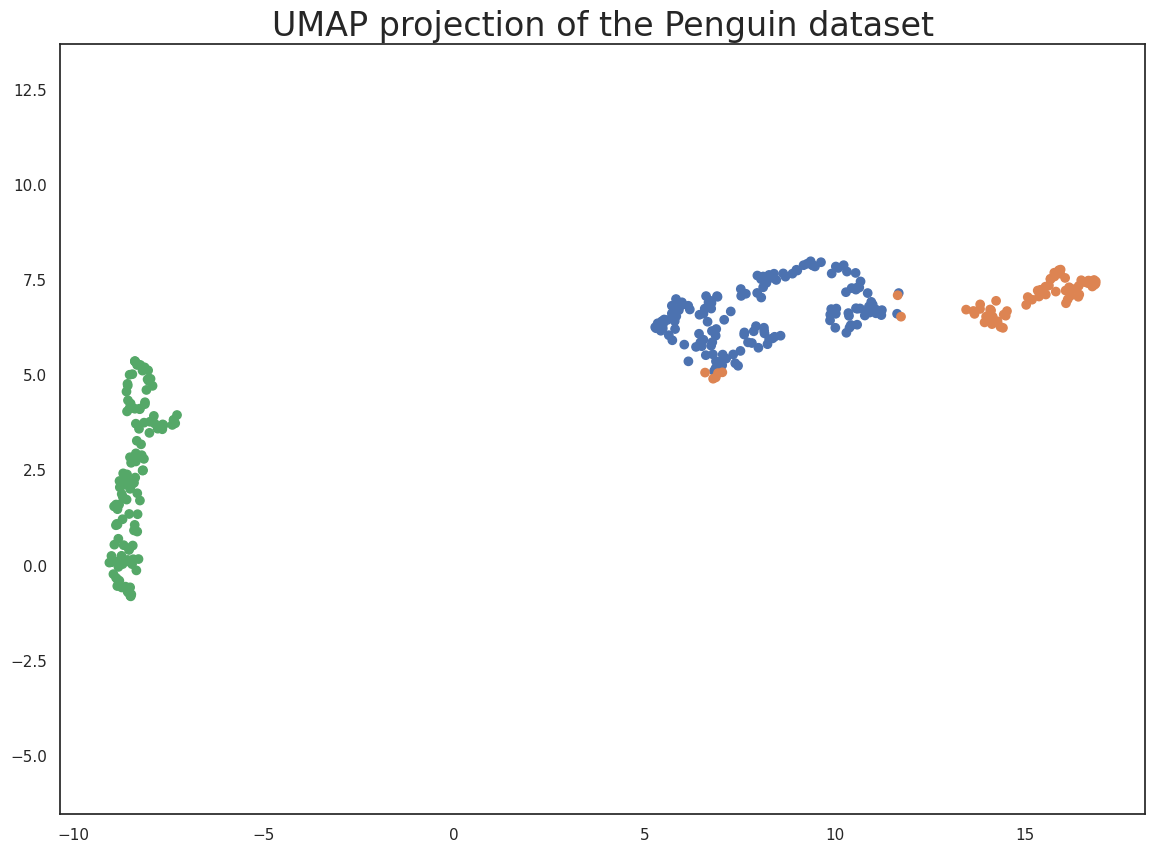

In [10]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in penguins.species.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Penguin dataset', fontsize=24);

In [11]:
digits = load_digits()
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

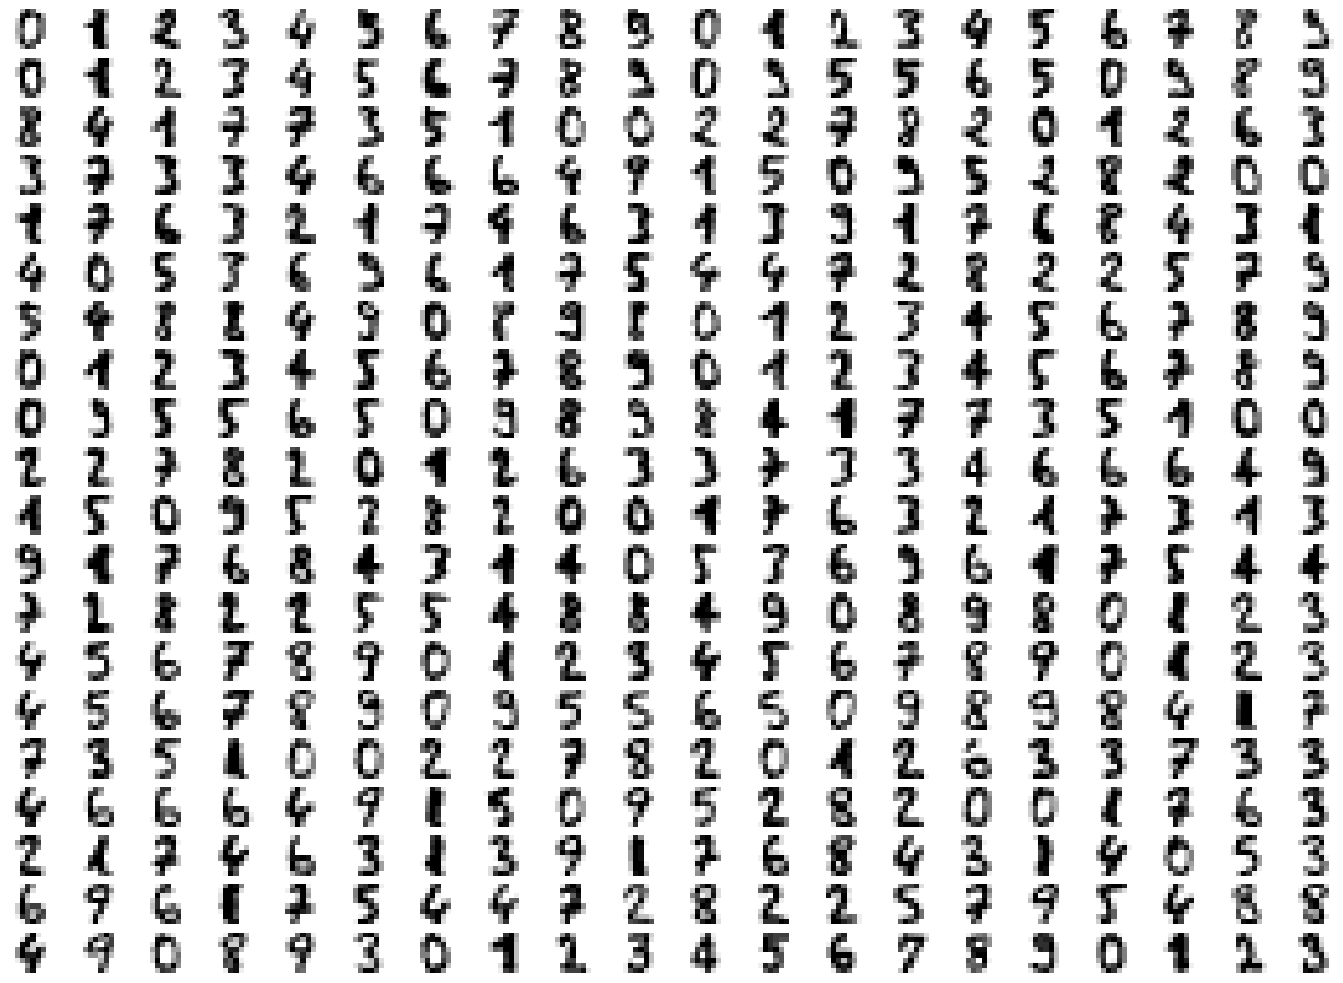

In [12]:
fig, ax_array = plt.subplots(20, 20)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray_r')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

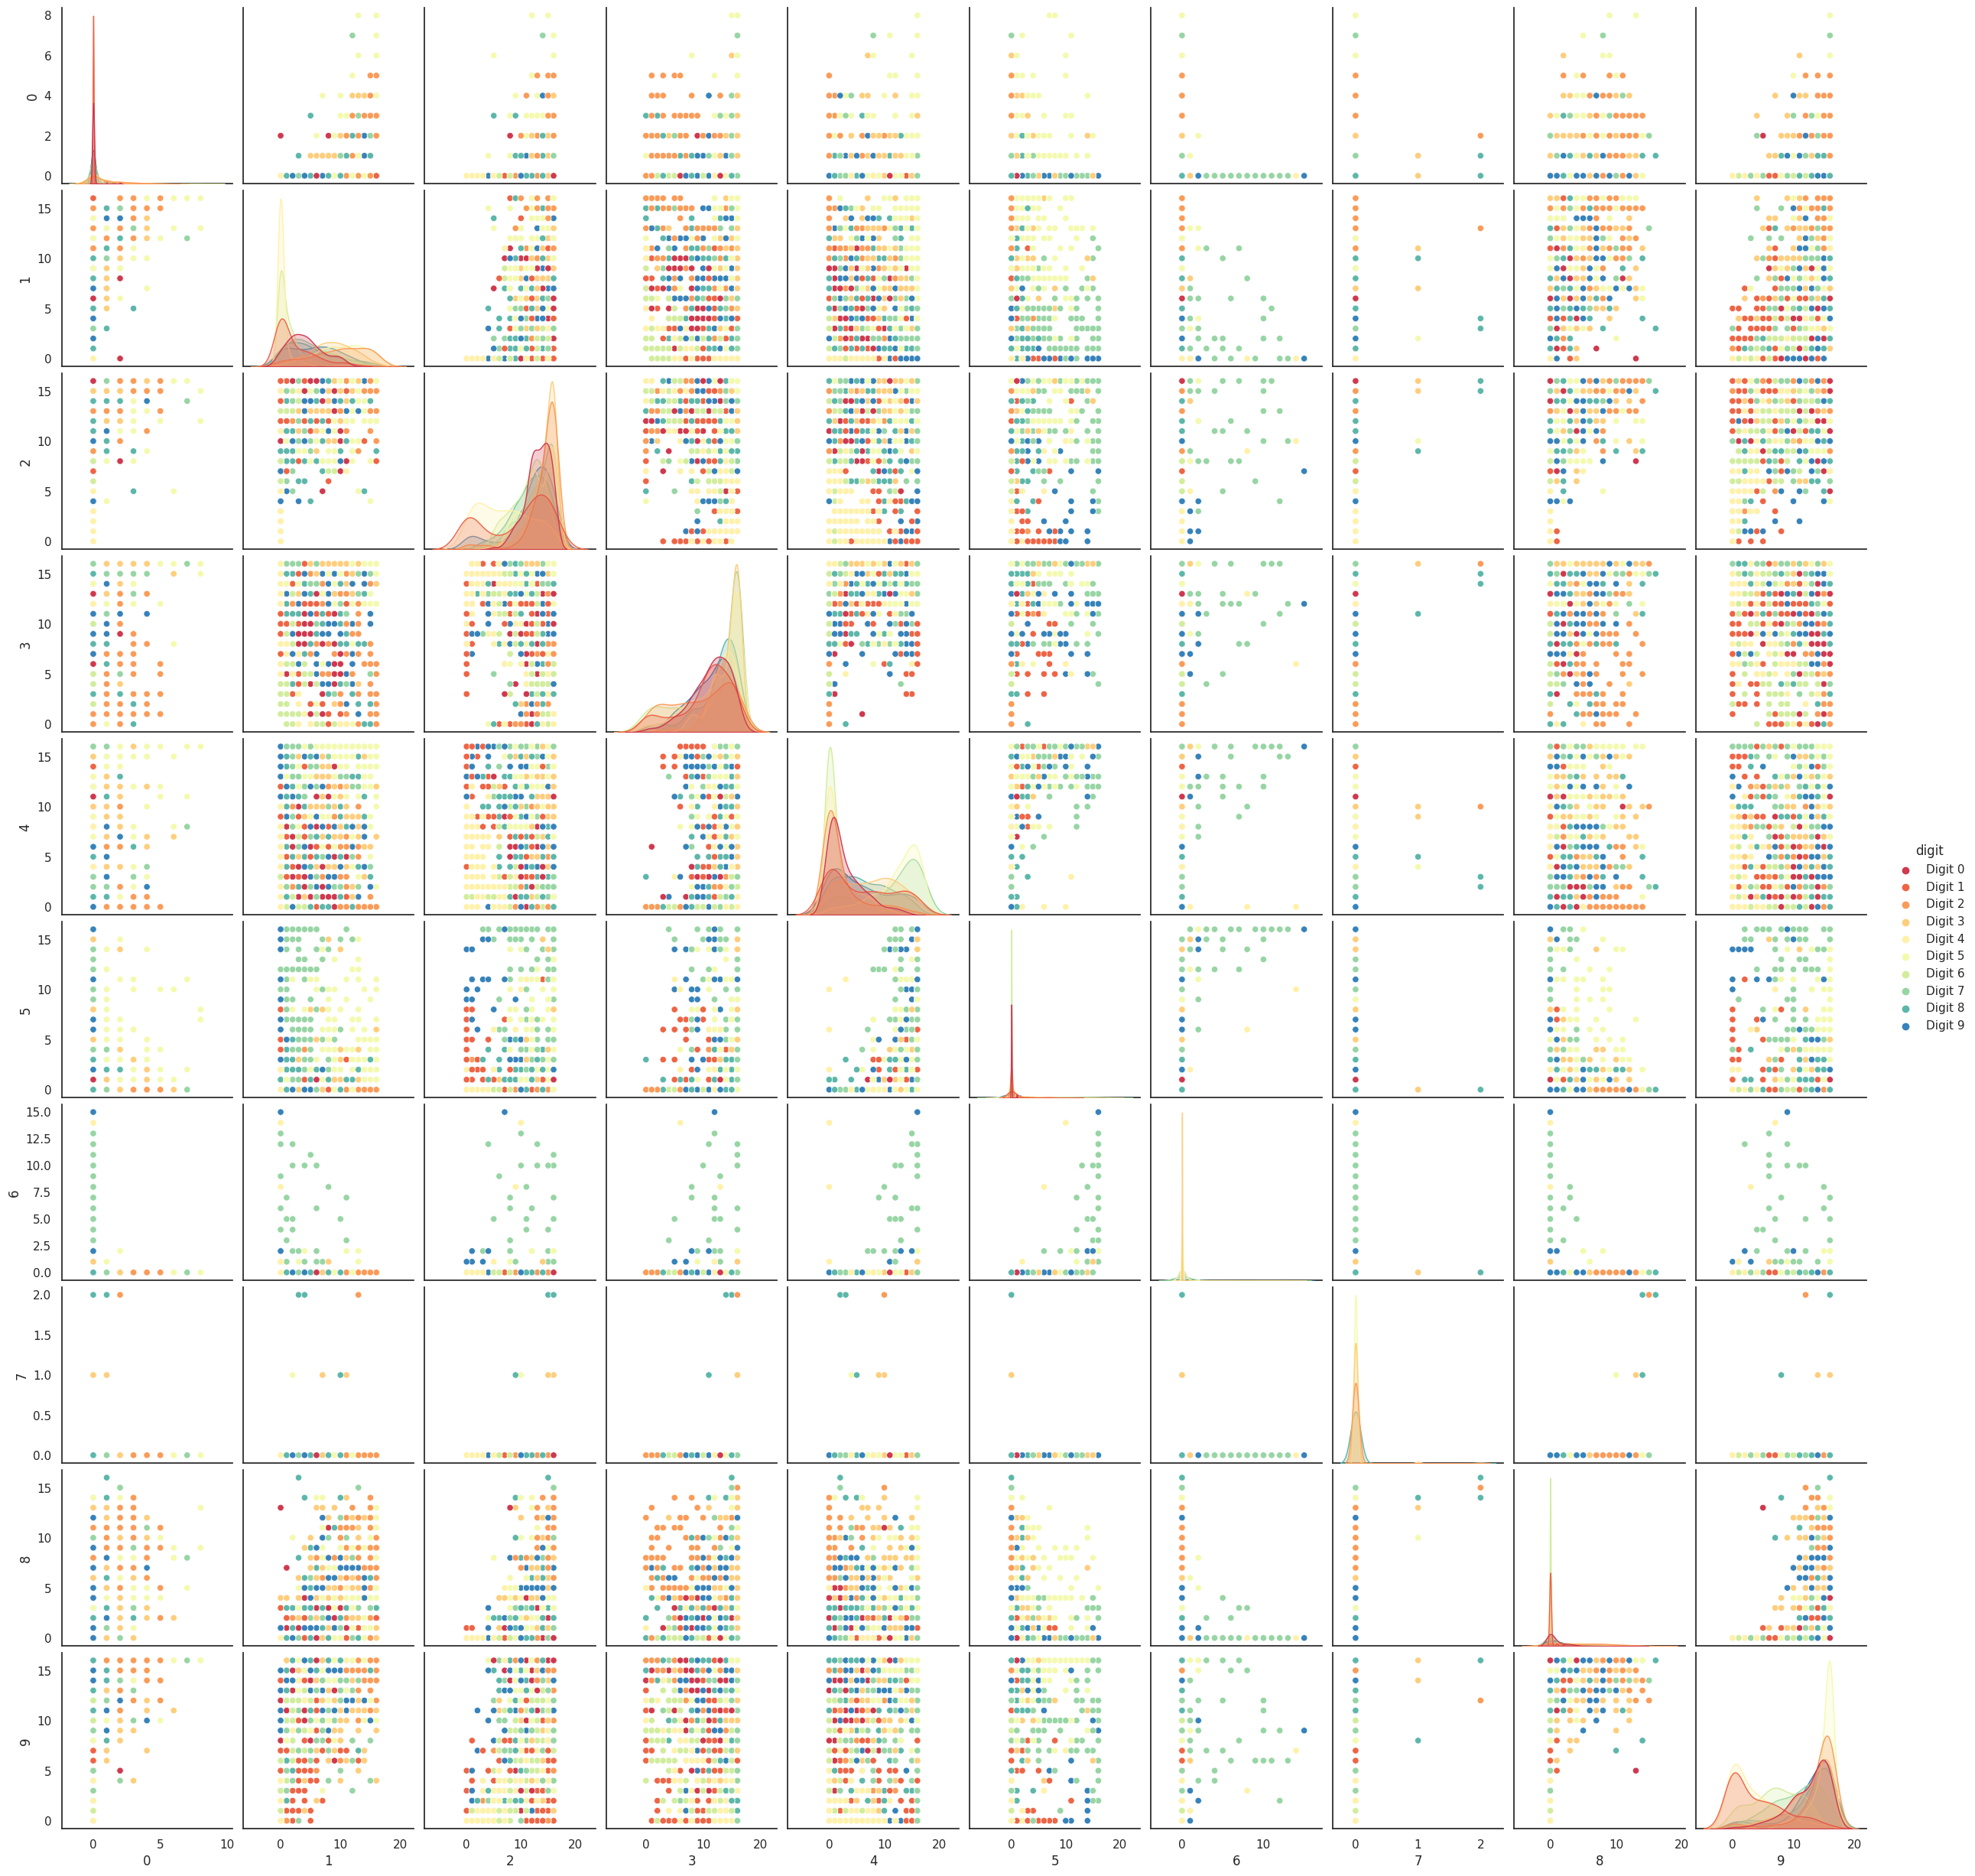

In [13]:
digits_df = pd.DataFrame(digits.data[:,1:11])
digits_df['digit'] = pd.Series(digits.target).map(lambda x: 'Digit {}'.format(x))
sns.pairplot(digits_df, hue='digit', palette='Spectral');

In [14]:
reducer = umap.UMAP(random_state=42)
reducer.fit(digits.data)

UMAP(random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [15]:
UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

NameError: name 'UMAP' is not defined

In [16]:
embedding = reducer.transform(digits.data)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(1797, 2)

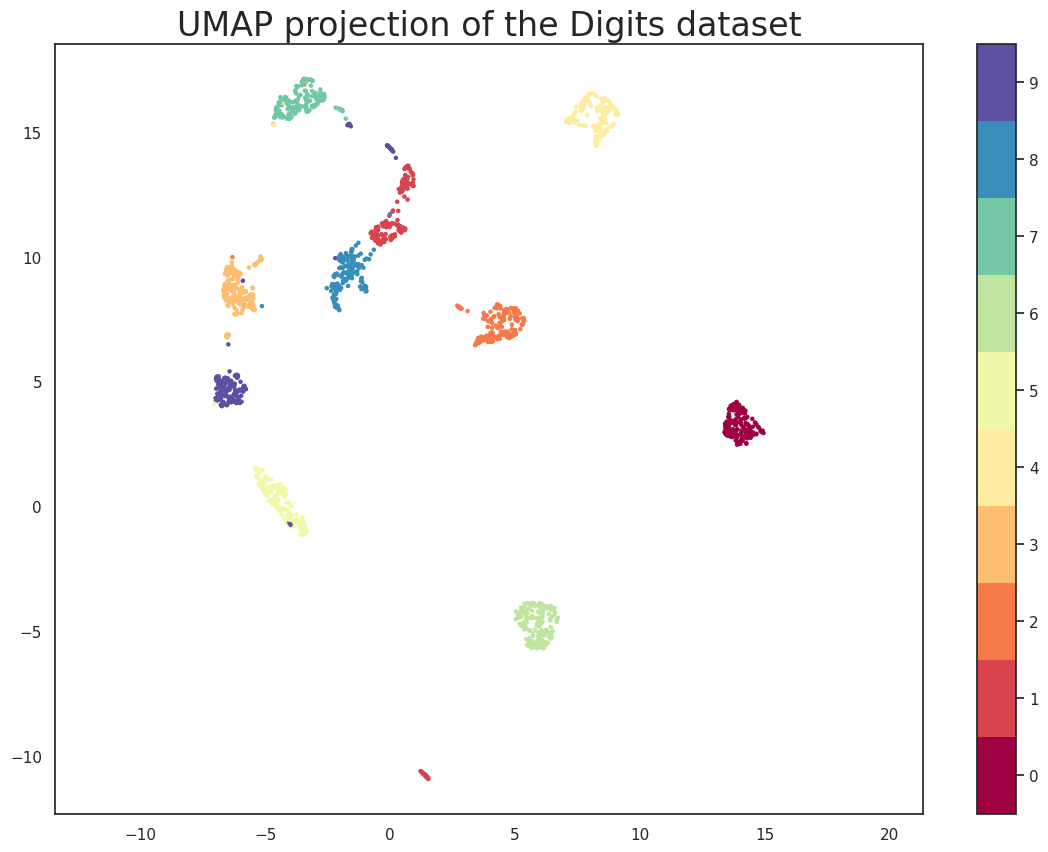

In [17]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

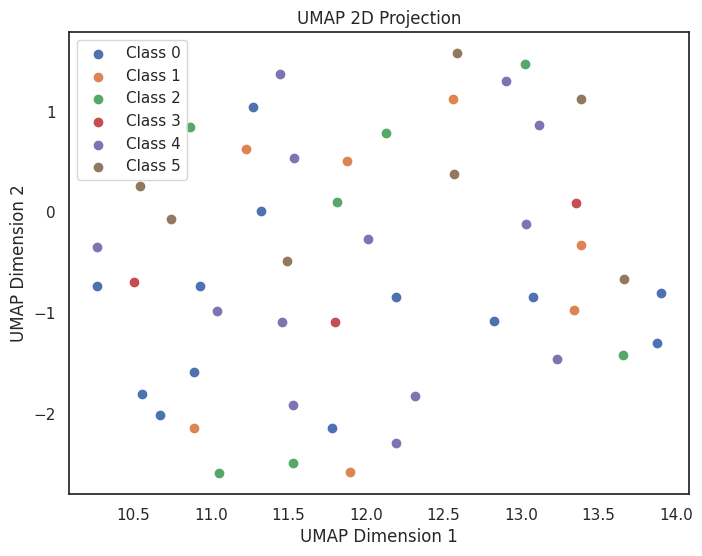

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP

# Generate example data
np.random.seed(42)
data = np.random.rand(50, 10)  # Your data of shape (50, n_features)
labels = np.random.randint(0, 6, size=50)  # Labels for the 6 classes

# Apply UMAP for dimensionality reduction
umap = UMAP(n_components=2, random_state=42)
reduced_data = umap.fit_transform(data)

# Create a scatter plot
plt.figure(figsize=(8, 6))
for class_label in range(6):
    plt.scatter(
        reduced_data[labels == class_label, 0],
        reduced_data[labels == class_label, 1],
        label=f'Class {class_label}',
    )

plt.title("UMAP 2D Projection")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.show()